In [1]:
%pip install optuna edge-ml tsflex plotly tsfresh torch timeout_decorator optunahub hebo ipywidgets
%pip install  pymoo

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 795.9/795.9 kB 47.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of gpy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 125.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 145.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 71.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 82.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 116.3 MB/s eta 0:00:0000:01
   ━

In [9]:
#%%markdown
from edgeml import DatasetReceiver
project=DatasetReceiver("https://beta.edge-ml.org","02a4fad735d3308b68672ddb7593f047")
project.loadData()

In [10]:
#%%markdown
import pickle
pickle.dump(project, open("data_snapshot/project_css25_py311_np123.pkl","wb"))

In [11]:
import pickle
import pandas as pd
project=pickle.load(open("data_snapshot/project_css25_py311_np123.pkl","rb"))

In [25]:
sensor = 'deviceorientation'

In [26]:
df=pd.concat([d.data.iloc[40:-40].dropna().assign(**d.metaData) for d  in project.datasets if (d.name == sensor and d.data.shape[0]>0) and d.timeSeries[0].end-d.timeSeries[0].start>10000] )
df.set_index(["participantId","time"], inplace=True)
df=df[df.activity!="testing"]
df

alpha       beta  gamma  activity  \
participantId time                                                              
10d83         2025-06-03 12:01:23.781   83.900002  58.700001    7.1   sitting   
              2025-06-03 12:01:23.798   84.000000  58.599998    7.0   sitting   
              2025-06-03 12:01:23.847   83.900002  58.700001    7.0   sitting   
              2025-06-03 12:01:23.865   83.900002  58.700001    7.1   sitting   
              2025-06-03 12:01:23.881   83.800003  58.599998    7.2   sitting   
...                                           ...        ...    ...       ...   
152a7         2025-07-07 14:36:18.050  262.799988  30.799999    1.1  standing   
              2025-07-07 14:36:18.067  262.899994  30.700001    1.0  standing   
              2025-07-07 14:36:18.083  263.000000  30.700001    0.8  standing   
              2025-07-07 14:36:18.100  263.100006  30.700001    0.6  standing   
              2025-07-07 14:36:18.133  263.299988  30.700001    0.5  standing   

                                             mobile browser  
participantId time                                           
10d83         2025-06-03 12:01:23.781  UnknownPhone  Chrome  
              2025-06-03 12:01:23.798  UnknownPhone  Chrome  
              2025-06-03 12:01:23.847  UnknownPhone  Chrome  
              2025-06-03 12:01:23.865  UnknownPhone  Chrome  
              2025-06-03 12:01:23.881  UnknownPhone  Chrome  
...                                             ...     ...  
152a7         2025-07-07 14:36:18.050  UnknownPhone  Chrome  
              2025-07-07 14:36:18.067  UnknownPhone  Chrome  
              2025-07-07 14:36:18.083  UnknownPhone  Chrome  
              2025-07-07 14:36:18.100  UnknownPhone  Chrome  
              2025-07-07 14:36:18.133  UnknownPhone  Chrome  

[89730 rows x 6 columns]

In [18]:
ts_cols=[col for col in df.columns if col not in ["activity","mobile","browser"] ]
ts_cols

['alpha', 'beta', 'gamma']

In [19]:
from tsflex.features import FeatureCollection, FuncWrapper, MultipleFeatureDescriptors
from tsflex.processing import SeriesProcessor
from tsflex.features.integrations import tsfresh_settings_wrapper
from tsfresh.feature_extraction import MinimalFCParameters

import numpy as np

 

# Common statistical + signal features approximating TSFRESH minimal set
tsfresh_minimal_funcs =   [
        FuncWrapper(np.sum, output_names="sum"),
        FuncWrapper(np.median, output_names="median"),
        FuncWrapper(np.mean, output_names="mean"),
        FuncWrapper(lambda x: len(x), output_names="length"),
        FuncWrapper(np.std, output_names="std_dev"),
        FuncWrapper(np.var, output_names="var"),
        FuncWrapper(lambda x: np.sqrt(np.mean(np.square(x))), output_names="root_mean_square"),
        FuncWrapper(lambda x: np.max(x) if len(x) > 0 else np.nan, output_names="max"),
        FuncWrapper(lambda x: np.max(np.abs(x)) if len(x) > 0 else np.nan, output_names="abs_max"),
        FuncWrapper(lambda x: np.min(x) if len(x) > 0 else np.nan, output_names="min"),
    ]
#tsfresh_minimal_funcs=tsfresh_settings_wrapper(MinimalFCParameters())

window_ms=1000

fc = FeatureCollection( feature_descriptors = [ MultipleFeatureDescriptors(  
        series_names=ts_cols , 
        functions=tsfresh_minimal_funcs,
        windows=[f"{window_ms}ms"],
        strides=[f"{int(window_ms/10)}ms"]
        )
        ] )


In [22]:
# Prepare the groups
grouped = df.reset_index().set_index("time").groupby(["participantId", "activity"]).size()
grouped

participantId  activity
10d83          sitting      1184
               standing      997
               walking      2816
11416          sitting     25776
               walking     21984
12358          walking      1259
12f77          sitting      1027
150c9          walking      5474
152a7          standing     1298
15b85          sitting      3817
18582          sitting      3355
191d4          sitting      2127
19ee7          standing       60
               walking       818
1a045          sitting      1042
               standing      667
               walking       687
1b682          standing     1411
1b728          sitting        62
1b949          standing      789
               walking      6802
1dd54          sitting       914
1e570          standing      717
1f683          sitting      4647
dtype: int64

In [23]:
%env PYTHONWARNINGS=ignore

import warnings

from joblib import Parallel, delayed
from tqdm.notebook import tqdm




# Prepare the groups
grouped = df.reset_index().set_index("time").groupby(["participantId", "activity"])

# Optional: Convert to a list to avoid multiple iterations over the generator
grouped_items = list(grouped)

# Define your processing function
def process_group(pid, group):
    warnings.filterwarnings('ignore')
    feats=pd.concat(fc.calculate(group, n_jobs=1),axis=1)
    #display(feats)
    feats["participantId"]=pid[0]
    feats["activity"] = pid[1]
    return feats.dropna().reset_index().set_index(["participantId","time"])

# Wrap with tqdm for progress
results = Parallel(n_jobs=-1)(
    delayed(process_group)(pid, group)
    for pid, group in tqdm(grouped_items, desc="Processing groups")
)


df1=pd.concat(results, axis=0)
 #   display(all_feats)

df1

env: PYTHONWARNINGS=ignore


Processing groups:   0%|          | 0/24 [00:00<?, ?it/s]

alpha__sum__w=1s  alpha__median__w=1s  \
participantId time                                                             
10d83         2025-06-03 12:01:24.781       2515.500000            83.850006   
              2025-06-03 12:01:24.881       2431.700195            83.800003   
              2025-06-03 12:01:24.981       2516.600586            83.900002   
              2025-06-03 12:01:25.081       2433.200195            83.900002   
              2025-06-03 12:01:25.181       2349.600098            83.900002   
...                                                 ...                  ...   
1f683         2025-06-23 19:10:29.060        834.509949            12.525000   
              2025-06-23 19:10:29.160        824.580017            12.525000   
              2025-06-23 19:10:29.260        805.789978            12.525000   
              2025-06-23 19:10:29.360        782.669983            12.445000   
              2025-06-23 19:10:29.460        761.979980            11.900000   

                                       alpha__mean__w=1s  alpha__length__w=1s  \
participantId time                                                              
10d83         2025-06-03 12:01:24.781          83.849998                   30   
              2025-06-03 12:01:24.881          83.851730                   29   
              2025-06-03 12:01:24.981          83.886688                   30   
              2025-06-03 12:01:25.081          83.903458                   29   
              2025-06-03 12:01:25.181          83.914291                   28   
...                                                  ...                  ...   
1f683         2025-06-23 19:10:29.060          13.908499                   60   
              2025-06-23 19:10:29.160          13.743000                   60   
              2025-06-23 19:10:29.260          13.429833                   60   
              2025-06-23 19:10:29.360          13.044499                   60   
              2025-06-23 19:10:29.460          12.491475                   61   

                                       alpha__std_dev__w=1s  alpha__var__w=1s  \
participantId time                                                              
10d83         2025-06-03 12:01:24.781              0.117615          0.013833   
              2025-06-03 12:01:24.881              0.127633          0.016290   
              2025-06-03 12:01:24.981              0.145449          0.021155   
              2025-06-03 12:01:25.081              0.137672          0.018954   
              2025-06-03 12:01:25.181              0.132864          0.017653   
...                                                     ...               ...   
1f683         2025-06-23 19:10:29.060              2.439942          5.953319   
              2025-06-23 19:10:29.160              2.343845          5.493608   
              2025-06-23 19:10:29.260              2.063793          4.259242   
              2025-06-23 19:10:29.360              1.648176          2.716485   
              2025-06-23 19:10:29.460              1.103872          1.218534   

                                       alpha__root_mean_square__w=1s  \
participantId time                                                     
10d83         2025-06-03 12:01:24.781                      83.850075   
              2025-06-03 12:01:24.881                      83.851822   
              2025-06-03 12:01:24.981                      83.886795   
              2025-06-03 12:01:25.081                      83.903564   
              2025-06-03 12:01:25.181                      83.914391   
...                                                              ...   
1f683         2025-06-23 19:10:29.060                      14.120895   
              2025-06-23 19:10:29.160                      13.941437   
              2025-06-23 19:10:29.260                      13.587481   
              2025-06-23 19:10:29.360                      13.148212   
              2025-06-23 1

In [10]:
tsfresh_minimal_funcs

[FuncWrapper(sum, ['sum'], {}),
 FuncWrapper(median, ['median'], {}),
 FuncWrapper(mean, ['mean'], {}),
 FuncWrapper(<lambda>, ['length'], {}),
 FuncWrapper(std, ['std_dev'], {}),
 FuncWrapper(var, ['var'], {}),
 FuncWrapper(<lambda>, ['root_mean_square'], {}),
 FuncWrapper(<lambda>, ['max'], {}),
 FuncWrapper(<lambda>, ['abs_max'], {}),
 FuncWrapper(<lambda>, ['min'], {})]

In [11]:
df1

alpha__sum__w=1s  alpha__median__w=1s  \
participantId time                                                             
10d83         2025-06-03 12:01:24.781       2515.500000            83.850006   
              2025-06-03 12:01:24.881       2431.700195            83.800003   
              2025-06-03 12:01:24.981       2516.600586            83.900002   
              2025-06-03 12:01:25.081       2433.200195            83.900002   
              2025-06-03 12:01:25.181       2349.600098            83.900002   
...                                                 ...                  ...   
1f683         2025-06-23 19:10:29.060        834.509949            12.525000   
              2025-06-23 19:10:29.160        824.580017            12.525000   
              2025-06-23 19:10:29.260        805.789978            12.525000   
              2025-06-23 19:10:29.360        782.669983            12.445000   
              2025-06-23 19:10:29.460        761.979980            11.900000   

                                       alpha__mean__w=1s  alpha__length__w=1s  \
participantId time                                                              
10d83         2025-06-03 12:01:24.781          83.849998                   30   
              2025-06-03 12:01:24.881          83.851730                   29   
              2025-06-03 12:01:24.981          83.886688                   30   
              2025-06-03 12:01:25.081          83.903458                   29   
              2025-06-03 12:01:25.181          83.914291                   28   
...                                                  ...                  ...   
1f683         2025-06-23 19:10:29.060          13.908499                   60   
              2025-06-23 19:10:29.160          13.743000                   60   
              2025-06-23 19:10:29.260          13.429833                   60   
              2025-06-23 19:10:29.360          13.044499                   60   
              2025-06-23 19:10:29.460          12.491475                   61   

                                       alpha__std_dev__w=1s  alpha__var__w=1s  \
participantId time                                                              
10d83         2025-06-03 12:01:24.781              0.117615          0.013833   
              2025-06-03 12:01:24.881              0.127633          0.016290   
              2025-06-03 12:01:24.981              0.145449          0.021155   
              2025-06-03 12:01:25.081              0.137672          0.018954   
              2025-06-03 12:01:25.181              0.132864          0.017653   
...                                                     ...               ...   
1f683         2025-06-23 19:10:29.060              2.439942          5.953319   
              2025-06-23 19:10:29.160              2.343845          5.493608   
              2025-06-23 19:10:29.260              2.063793          4.259242   
              2025-06-23 19:10:29.360              1.648176          2.716485   
              2025-06-23 19:10:29.460              1.103872          1.218534   

                                       alpha__root_mean_square__w=1s  \
participantId time                                                     
10d83         2025-06-03 12:01:24.781                      83.850075   
              2025-06-03 12:01:24.881                      83.851822   
              2025-06-03 12:01:24.981                      83.886795   
              2025-06-03 12:01:25.081                      83.903564   
              2025-06-03 12:01:25.181                      83.914391   
...                                                              ...   
1f683         2025-06-23 19:10:29.060                      14.120895   
              2025-06-23 19:10:29.160                      13.941437   
              2025-06-23 19:10:29.260                      13.587481   
              2025-06-23 19:10:29.360                      13.148212   
              2025-06-23 1

In [ ]:
#...

In [30]:
from sklearn.model_selection import GroupShuffleSplit

# Group-based train-test-split -> groups are not split but entirely assigned to either training or testing
splitter = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)


for train_idx, test_idx in splitter.split(y=df1.activity, X=df1.drop(columns=["activity"]), groups=df1.reset_index().participantId):
    train, test = df1.iloc[train_idx], df1.iloc[test_idx]

In [31]:
test.reset_index().participantId.unique()

array(['10d83', '11416'], dtype=object)

In [32]:
train.reset_index().participantId.unique()

array(['12358', '12f77', '150c9', '152a7', '15b85', '18582', '191d4',
       '19ee7', '1a045', '1b682', '1b728', '1b949', '1dd54', '1e570',
       '1f683'], dtype=object)

In [15]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [16]:
train.activity.factorize()

(array([0, 0, 0, ..., 1, 1, 1]),
 Index(['walking', 'sitting', 'standing'], dtype='object'))

In [35]:
from sklearn.model_selection import  GroupKFold

X,y,groups= train.drop(columns=["activity"]), train.activity, train.reset_index().participantId
cv = GroupKFold(n_splits=5)
splits=list(cv.split(X, y, groups))

In [42]:
import optuna
import optunahub
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier, Perceptron
)
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.utils import all_estimators
import timeout_decorator
import random




#@timeout_decorator.timeout(30, timeout_exception=optuna.TrialPruned, use_signals=True)
def cross_val_score_to(clf,X,y,cv=None, groups=None, scoring=None):
    cross_val_score(clf,X,y,cv=cv, groups=groups, scoring=scoring)

clfs={
        "lr": LogisticRegression,
        "ridge": RidgeClassifier,
        "sgd": SGDClassifier,
        "lsvc": LinearSVC,
        "svc": SVC,
        "pac": PassiveAggressiveClassifier,
        "perc": Perceptron,
        "dt": DecisionTreeClassifier,
        "et": ExtraTreeClassifier,
        "rf":RandomForestClassifier,
        "etrees":ExtraTreesClassifier,
     }

def objective(trial):
    from sklearn.datasets import load_iris  # replace with your data

    model_name = trial.suggest_categorical("classifier", clfs.keys())

    if model_name == "lr":
        clf = LogisticRegression(
            C=trial.suggest_float("lr_C", 1e-3, 100, log=True),
            solver="liblinear"
        )
    elif model_name == "ridge":
        clf = RidgeClassifier(
            alpha=trial.suggest_float("ridge_alpha", 1e-3, 10, log=True)
        )
    elif model_name == "sgd":
        clf = SGDClassifier(
            loss=trial.suggest_categorical("sgd_loss", ["hinge", "log_loss"]),
            alpha=trial.suggest_float("sgd_alpha", 1e-5, 1e-1, log=True),
            max_iter=1000,
            tol=1e-3
        )
    elif model_name == "lsvc":
        clf = LinearSVC(
            C=trial.suggest_float("lsvc_C", 1e-3, 100, log=True),
            max_iter=100
        )
    elif model_name == "svc":
        clf = SVC(
            C=trial.suggest_float("svc_C", 1e-3, 100, log=True),
            kernel=trial.suggest_categorical("svc_kernel", ["linear", "rbf"]),
            gamma=trial.suggest_categorical("svc_gamma", ["scale", "auto"]),
            max_iter=100
        )
    elif model_name == "pac":
        clf = PassiveAggressiveClassifier(
            C=trial.suggest_float("pac_C", 1e-3, 10, log=True)
        )
    elif model_name == "perc":
        clf = Perceptron(
            alpha=trial.suggest_float("perc_alpha", 1e-5, 1e-1, log=True),
            max_iter=1000
        )
    elif model_name == "dt":
        clf = DecisionTreeClassifier(
            max_depth=trial.suggest_int("dt_max_depth", 2, 20),
            min_samples_split=trial.suggest_int("dt_min_samples_split", 2, 10)
        )
    elif model_name == "et":
        clf = ExtraTreeClassifier(
            max_depth=trial.suggest_int("et_max_depth", 2, 20),
            min_samples_split=trial.suggest_int("et_min_samples_split", 2, 10)
        )
    elif model_name == "rf":
        clf = RandomForestClassifier(
            n_estimators=trial.suggest_int("rf_n_estimators", 50, 200),
            max_depth=trial.suggest_int("rf_max_depth", 2, 20),
            min_samples_split=trial.suggest_int("rf_min_samples_split", 2, 10)
        )
    elif model_name == "etrees":
        clf = ExtraTreesClassifier(
            n_estimators=trial.suggest_int("etrees_n_estimators", 50, 200),
            max_depth=trial.suggest_int("etrees_max_depth", 2, 20),
            min_samples_split=trial.suggest_int("etrees_min_samples_split", 2, 10)
        )
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # Pipeline with scaling (important for linear models and SVMs)
    pipeline = make_pipeline(RobustScaler(), clf)
    #return cross_val_score(clf,X,y,cv=cv, groups=groups, scoring="f1_macro").mean()

    def evaluate_model(split):
        train_idx, test_idx = split
        pipeline.fit(X.iloc[train_idx], y.iloc[train_idx])
        y_pred = pipeline.predict(X.iloc[test_idx])
        return f1_score(y.iloc[test_idx], y_pred, average='macro')
    
    ssplits = random.sample(splits, 3)
    # Run the evaluation 3 times in parallel
    return np.median(Parallel(n_jobs=3)(delayed(evaluate_model)(split) for split in ssplits))

module = optunahub.load_module("samplers/hebo")
sampler = module.HEBOSampler()

study= optuna.study.create_study(sampler= sampler, direction="maximize")
study.optimize(objective,n_trials=500, n_jobs=-1, timeout=60, show_progress_bar=True)

[I 2025-07-15 10:44:18,584] A new study created in memory with name: no-name-4b5a4209-cff4-484b-9f96-bce691b121a6


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-07-15 10:44:20,263] Trial 111 finished with value: 0.5427211020496656 and parameters: {'classifier': 'dt', 'dt_max_depth': 17, 'dt_min_samples_split': 7}. Best is trial 111 with value: 0.5427211020496656.
[I 2025-07-15 10:44:20,423] Trial 0 finished with value: 0.41299880525686977 and parameters: {'classifier': 'pac', 'pac_C': 1.046589706409247}. Best is trial 111 with value: 0.5427211020496656.
[I 2025-07-15 10:44:20,774] Trial 112 finished with value: 0.3095284328771128 and parameters: {'classifier': 'et', 'et_max_depth': 6, 'et_min_samples_split': 8}. Best is trial 111 with value: 0.5427211020496656.
jitter = 1e-07
jitter = 1e-06
jitter = 9.999999999999999e-06
jitter = 9.999999999999999e-05
jitter = 0.001
jitter = 0.01
jitter = 0.1
jitter = 1.0
jitter = 10.0
jitter is too large, give up fitting GP
jitter = 1e-07
jitter = 1e-06
jitter = 9.999999999999999e-06
jitter = 9.999999999999999e-05
jitter = 0.001
jitter = 0.01
jitter = 0.1
jitter = 1.0
jitter = 10.0
jitter is too large

In [43]:
trial=study.ask()

(objective(trial),trial.params)

[W 2025-07-15 10:46:55,384] Use `RandomSampler` for dt_max_depth due to dynamic search space.
[W 2025-07-15 10:46:55,385] Use `RandomSampler` for dt_min_samples_split due to dynamic search space.


(0.43284416778617557,
 {'classifier': 'dt', 'dt_max_depth': 8, 'dt_min_samples_split': 3})

In [44]:
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)  


In [46]:
optuna.visualization.plot_optimization_history(study)

In [47]:
params=trial.params
clf_str=params.pop("classifier", None)

optuna.visualization.plot_contour(study,params.keys())

In [54]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_classifier,params_dt_max_depth,params_dt_min_samples_split,params_et_max_depth,params_et_min_samples_split,...,params_rf_max_depth,params_rf_min_samples_split,params_rf_n_estimators,params_ridge_alpha,params_sgd_alpha,params_sgd_loss,params_svc_C,params_svc_gamma,params_svc_kernel,state
0,0,0.445499,2025-07-13 12:23:51.040635,2025-07-13 12:23:54.433487,0 days 00:00:03.392852,pac,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
1,1,0.350314,2025-07-13 12:23:51.041074,2025-07-13 12:23:53.965345,0 days 00:00:02.924271,pac,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
2,2,0.493960,2025-07-13 12:23:51.041476,2025-07-13 12:23:51.765870,0 days 00:00:00.724394,sgd,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.011135,hinge,NaN,NaN,NaN,COMPLETE
3,3,0.299205,2025-07-13 12:23:51.041881,2025-07-13 12:23:53.944868,0 days 00:00:02.902987,pac,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
4,4,0.403094,2025-07-13 12:23:51.042254,2025-07-13 12:23:51.585727,0 days 00:00:00.543473,etrees,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,272,NaN,2025-07-13 12:29:45.941842,NaT,NaT,lr,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RUNNING
273,273,NaN,2025-07-13 12:29:48.305010,NaT,NaT,lr,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RUNNING
274,274,NaN,2025-07-13 12:29:50.554412,NaT,NaT,lr,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RUNNING
275,275,NaN,2025-07-13 12:30:16.470036,NaT,NaT,rf,NaN,NaN,NaN,NaN,...,12.0,9.0,184.0,NaN,NaN,NaN,NaN,NaN,NaN,RUNNING


In [48]:
params={k.removeprefix(clf_str+"_"): v for k, v in params.items()}
 
clf=clfs[clf_str](**params)
clf

DecisionTreeClassifier(max_depth=8, min_samples_split=3)

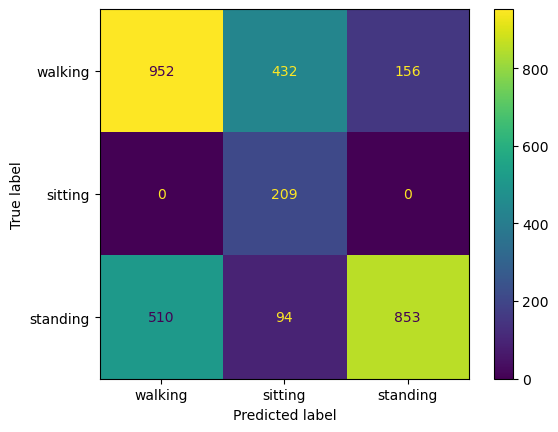

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
scaler=RobustScaler()
pipeline = make_pipeline(scaler, clf)
pipeline.fit(train.drop(columns=["activity"]),train.activity)
cm = confusion_matrix(test.activity, pipeline.predict(test.drop(columns=["activity"])))
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=train.activity.unique()).plot()

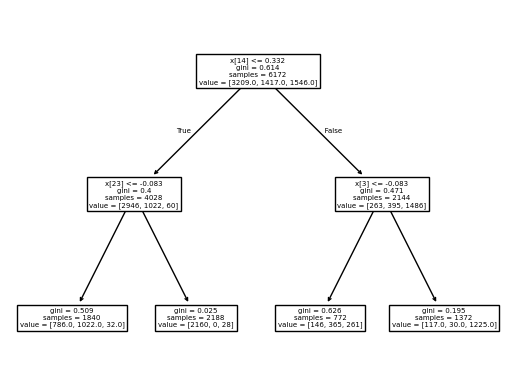

In [69]:
from sklearn import tree

if( isinstance(clf,DecisionTreeClassifier) ): 
    tree.plot_tree(clf)

In [58]:
%pip install m2cgen

Note: you may need to restart the kernel to use updated packages.


In [70]:
import m2cgen as m2c
code = m2c.export_to_javascript(clf)


In [71]:
pipeline.feature_names_in_

array(['alpha__sum__w=1s', 'alpha__median__w=1s', 'alpha__mean__w=1s',
       'alpha__length__w=1s', 'alpha__std_dev__w=1s', 'alpha__var__w=1s',
       'alpha__root_mean_square__w=1s', 'alpha__max__w=1s',
       'alpha__abs_max__w=1s', 'alpha__min__w=1s', 'beta__sum__w=1s',
       'beta__median__w=1s', 'beta__mean__w=1s', 'beta__length__w=1s',
       'beta__std_dev__w=1s', 'beta__var__w=1s',
       'beta__root_mean_square__w=1s', 'beta__max__w=1s',
       'beta__abs_max__w=1s', 'beta__min__w=1s', 'gamma__sum__w=1s',
       'gamma__median__w=1s', 'gamma__mean__w=1s', 'gamma__length__w=1s',
       'gamma__std_dev__w=1s', 'gamma__var__w=1s',
       'gamma__root_mean_square__w=1s', 'gamma__max__w=1s',
       'gamma__abs_max__w=1s', 'gamma__min__w=1s'], dtype=object)

In [72]:
import json
scaler_str=json.dumps(
    {
        "scale": list(scaler.scale_),
        "center": list(scaler.center_),
        "name": type(scaler).__name__
    })
print(scaler_str)

{"scale": [15991.11393737793, 334.0599994659424, 326.93214988708496, 18.0, 6.263924658298492, 40.18094332970213, 327.2997045516968, 343.2225093841553, 343.2225093841553, 324.8499927520752, 823.8525314331055, 14.047500848770142, 13.217953562736511, 18.0, 2.8270509243011475, 8.450372992781922, 12.206010341644287, 14.499999046325684, 14.399999618530273, 16.379999458789825, 356.83997535705566, 8.275000095367432, 8.273346364498138, 18.0, 2.6020041089504957, 7.291431987890974, 6.9354153871536255, 10.420000314712524, 9.520000219345093, 7.400000192224979], "center": [3558.9498291015625, 81.44999694824219, 89.91036605834961, 60.0, 0.7842418849468231, 0.6150353252887726, 92.0, 92.85000228881836, 92.85000228881836, 25.8100004196167, 599.0, 11.822499752044678, 11.935165882110596, 60.0, 0.3566865622997284, 0.12722530215978622, 13.685166835784912, 15.78499984741211, 16.739999771118164, 9.600000381469727, -26.340003967285156, -0.4399999976158142, -0.44150006771087646, 60.0, 0.5153481066226959, 0.2655

In [73]:
#
js=f"""{code}

const classifier =
{{ 
 inputs: {json.dumps(ts_cols)} ,
 classes: {json.dumps(list(clf.classes_))} ,
 window: {0-window_ms},
 score: score , 
 scale: {scaler_str}
}}
;

if (typeof window !== 'undefined') {{
window.{sensor}_model=classifier;
}}

if (typeof module !== 'undefined') {{
module.exports = classifier;
}}

"""

with open(f"data_snapshot/{sensor}_model.mjs", "w") as file:
    file.write(js)